In [78]:
import os
from ast import literal_eval
from datetime import datetime
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mlflow
from sklearn.model_selection import train_test_split

sns.set_theme(style='white')
sns.set_theme(rc={'axes.facecolor':'#FFEFD5','figure.facecolor':'#FFEFD5'})
sns.set_context('poster',font_scale = .7)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602', '#9B59B6', '#E74C3C']

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

DATA_DIR = Path().resolve().parent / 'data'

In [38]:
def check_df(dataframe, head=5):
    print('SHAPE'.center(70,'-'))
    print(dataframe.shape)
    print('HEAD'.center(70,'-'))
    print(dataframe.head(head))
    print('INFO'.center(70,'-'))
    print(dataframe.info())
    print('NUNIQUE'.center(70,'-'))
    print(dataframe.nunique())
    print('MISSING VALUES'.center(70,'-'))
    print(dataframe.isnull().sum())
    print('DUPLICATED ROWS'.center(70,'-'))
    print(dataframe.duplicated().sum())


def plot_numeric_col(data, column, bins=30, figsize=(16, 8)):
    """
    Создает комплексный график для количественной переменной
    """
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])

    # Гистограмма с KDE
    ax1 = plt.subplot(gs[0, :])
    sns.histplot(data=data, x=column, bins=bins, kde=True,
                color=colors[0], alpha=0.7, ax=ax1)
    ax1.axvline(data[column].mean(), color='red', linestyle='--',
               label=f'Mean: {data[column].mean():.2f}')
    ax1.axvline(data[column].median(), color='green', linestyle='--',
               label=f'Median: {data[column].median():.2f}')
    ax1.set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Frequency', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot
    ax2 = plt.subplot(gs[1, 0])
    sns.boxplot(x=data[column], color=colors[1], ax=ax2)
    ax2.set_title(f'Boxplot of {column}', fontsize=14)
    ax2.set_xlabel(column, fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Violin plot
    ax3 = plt.subplot(gs[1, 1])
    sns.violinplot(x=data[column], color=colors[2], ax=ax3)
    ax3.set_title(f'Violin Plot of {column}', fontsize=14)
    ax3.set_xlabel(column, fontsize=12)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_categorical_col(data, column, top_n=10, figsize=(16, 8)):
    """
    Комплексный график для категориальной переменной
    """
    # Подготовка данных
    value_counts = data[column].value_counts()
    if len(value_counts) > top_n:
        top_categories = value_counts.head(top_n)
        other_count = value_counts[top_n:].sum()
        top_categories['Other'] = other_count
    else:
        top_categories = value_counts

    # Создание subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Столбчатая диаграмма
    bars = ax1.bar(range(len(top_categories)), top_categories.values,
                  color=colors[:len(top_categories)], alpha=0.8)
    ax1.set_title(f'Bar Chart of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.set_xticks(range(len(top_categories)))
    ax1.set_xticklabels(top_categories.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontsize=10)

    # Круговая диаграмма
    wedges, texts, autotexts = ax2.pie(top_categories.values,
                                      labels=top_categories.index,
                                      autopct='%1.1f%%',
                                      colors=colors[:len(top_categories)],
                                      startangle=90)
    ax2.set_title(f'Pie Chart of {column}', fontsize=16, fontweight='bold')

    # Улучшение читаемости
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

## Загрузка и предобработка данных

In [39]:
df = pd.read_csv(DATA_DIR / 'Spb_flats_prices.csv')
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 9)
---------------------------------HEAD---------------------------------
                                   Underground Times  \
0  {'Underground name': ['Балтийская', 'Василеост...   
1  {'Underground name': ['Московская', 'Бухарестс...   
2  {'Underground name': ['Василеостровская', 'Спо...   
3  {'Underground name': ['Улица Дыбенко', 'Проспе...   
4  {'Underground name': ['Девяткино', 'Граждански...   

   Flat Status (1 - handed over, 0 - not handed over) Flat Type  \
0                                                  1     4-комн   
1                                                  1     2-комн   
2                                                  0     3-комн   
3                                                  1     2-комн   
4                                                  1     1-комн   

   Total Area (m^2)  Living Area (m^2)  Kitchen Area (m^2)  Floor  \
0            125.50               75.8 

In [40]:
df.columns = ['metro_info',
             'flat_status',
             'num_of_rooms',
             'total_area_m2',
             'living_area_m2',
             'kitchen_area_m2',
             'floor',
             'year_of_bulding',
             'price']

In [41]:
def nearest_metro_station(json):
    stations_dict = literal_eval(json)

    nearest_station = stations_dict['Underground name'][0]
    time_to_get = stations_dict['Underground time'][0]
    way_to_get_to = stations_dict['Transport type'][0]

    return [nearest_station, time_to_get, way_to_get_to]

In [42]:
df[['metro_station',
    'minutes_to_metro',
    'transfer_type']] = pd.DataFrame(df['metro_info'].apply(lambda x: nearest_metro_station(x)).tolist(),
                                     index=df.index)
df.drop('metro_info', axis=1, inplace=True)

In [43]:
df['num_of_rooms'].unique()

array(['4-комн', '2-комн', '3-комн', '1-комн', '5-комн', 'Студия',
       'Многокомнатны', 'Многокомнатна', 'Апартаменты-студия', '15/4',
       'Квартир', '29/4'], dtype=object)

In [44]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: 'Неизвестно' if x in ['Многокомнатны',
                                                                          'Многокомнатна',
                                                                          '15/4',
                                                                          'Квартир',
                                                                          '29/4'] else x)

In [45]:
replacements = {
    'Апартаменты-студия': 'Студия',
    '1-комн': '1-комнатная'
}
df['num_of_rooms'] = df['num_of_rooms'].replace('Апартаменты-студия', 'Студия')

In [46]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: x + 'атная' if x not in ['Студия', 'Неизвестно'] else x)

In [47]:
df['num_of_rooms'].unique()

array(['4-комнатная', '2-комнатная', '3-комнатная', '1-комнатная',
       '5-комнатная', 'Студия', 'Неизвестно'], dtype=object)

In [48]:
df.duplicated().sum()

np.int64(82)

In [49]:
current_year = datetime.now().year
df['house_age'] = (current_year - df['year_of_bulding']).apply(lambda x: x if x > 0 else 0)

In [50]:
df['is_future_building'] = (df['year_of_bulding'] > current_year).astype(int)
df.drop('year_of_bulding', axis=1, inplace=True)

In [51]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,car,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,car,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,legs,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,car,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,car,10,0


In [52]:
df['minutes_to_metro'] = df['minutes_to_metro'].replace('откроется', 10).astype(int)

In [53]:
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 12)
---------------------------------HEAD---------------------------------
   flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-комнатная         125.50            75.8             22.9   
1            1  2-комнатная          41.50            26.4              6.0   
2            0  3-комнатная          80.39            44.9             10.2   
3            1  2-комнатная          65.10            27.0             19.0   
4            1  1-комнатная          38.50            16.6             10.5   

   floor     price     metro_station  minutes_to_metro transfer_type  \
0      4  24500000        Балтийская                 5           car   
1      3   6300000        Московская                 6           car   
2      3  30061520  Василеостровская                11          legs   
3      4  11500000     Улица Дыбенко                 7           car   
4     10   5

In [54]:
df.drop_duplicates(inplace=True)

## EDA

In [55]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,car,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,car,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,legs,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,car,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,car,10,0


In [56]:
shape_before_eda = df.shape

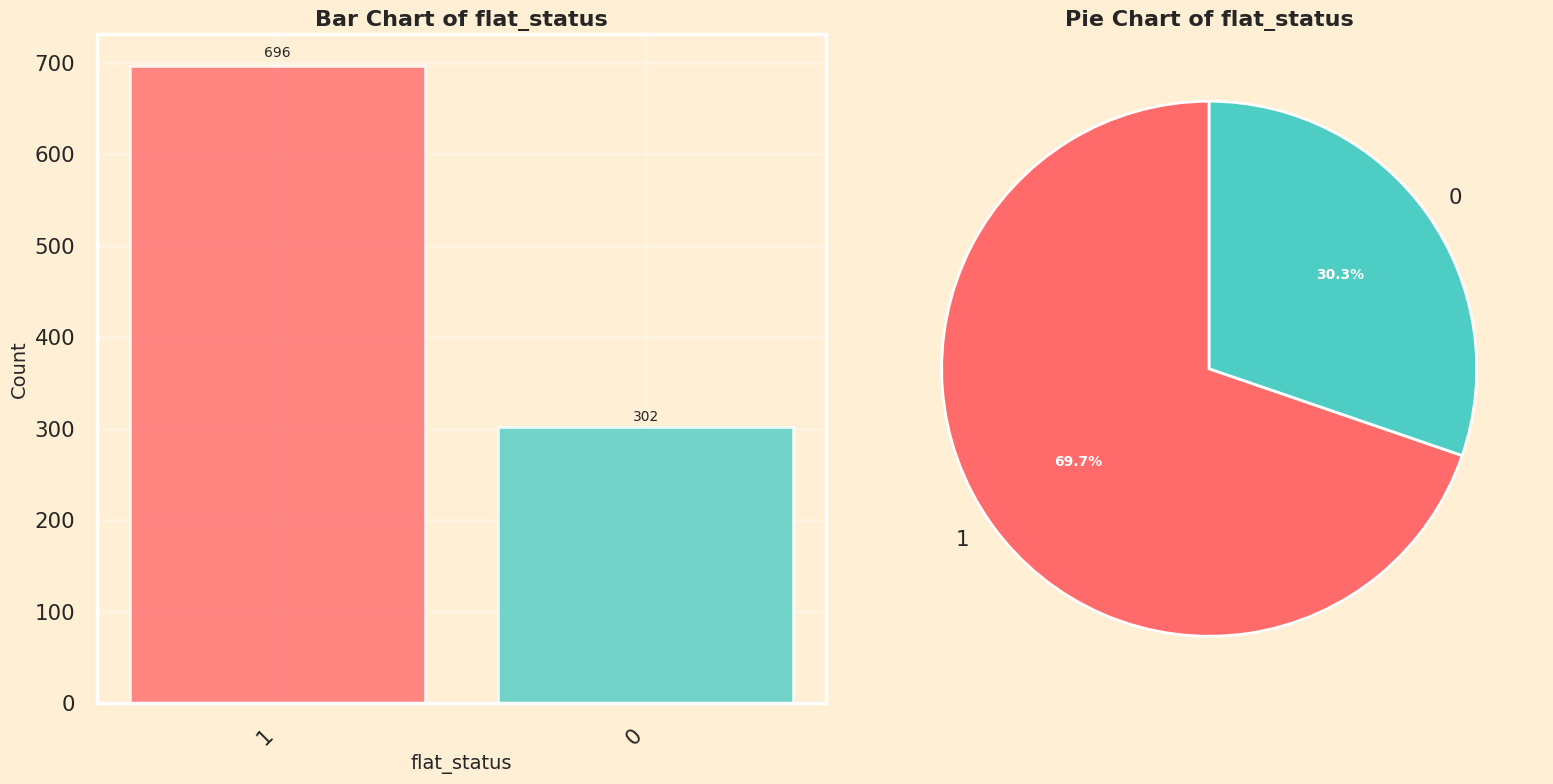

In [57]:
plot_categorical_col(df, 'flat_status')

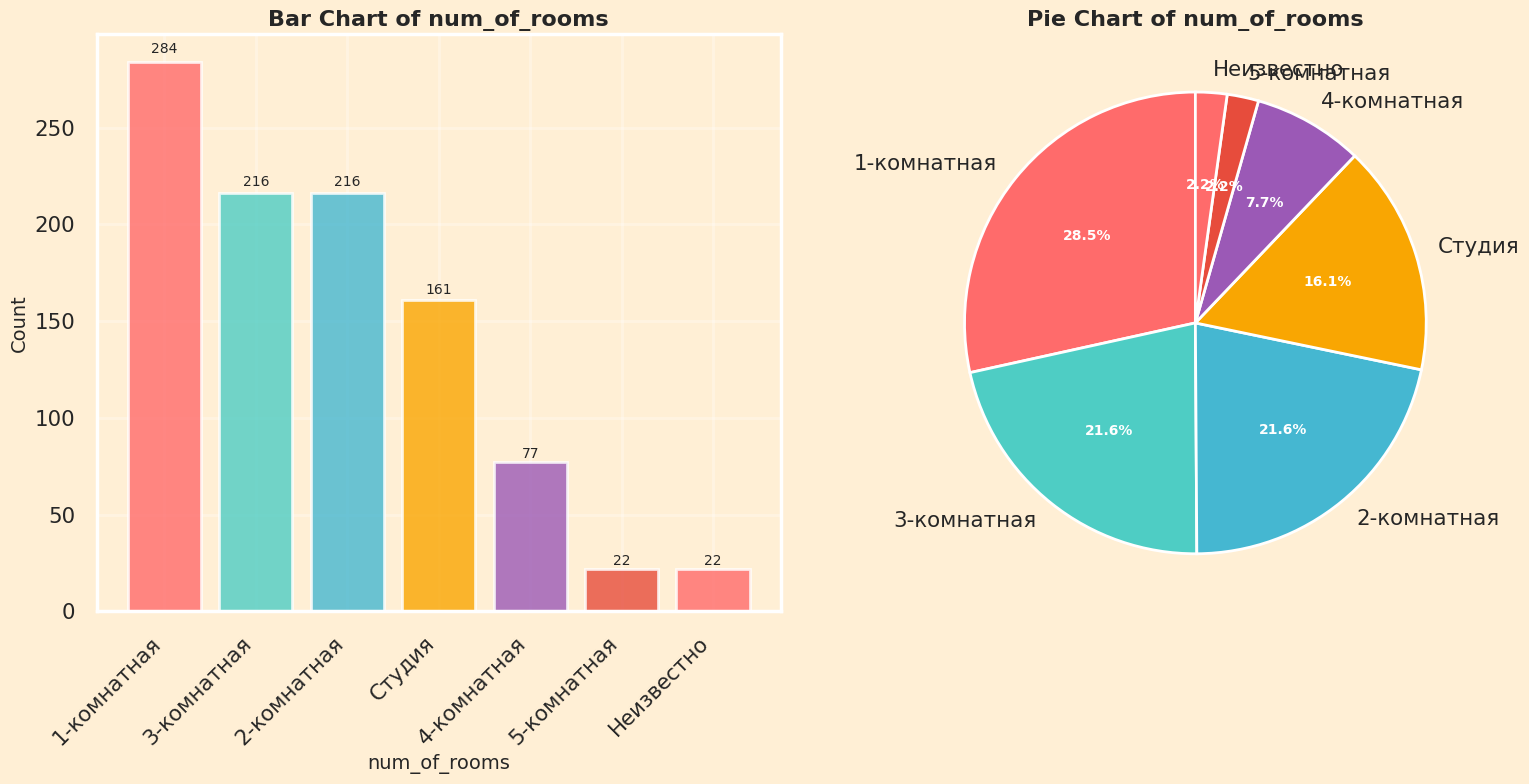

In [58]:
plot_categorical_col(df, 'num_of_rooms')

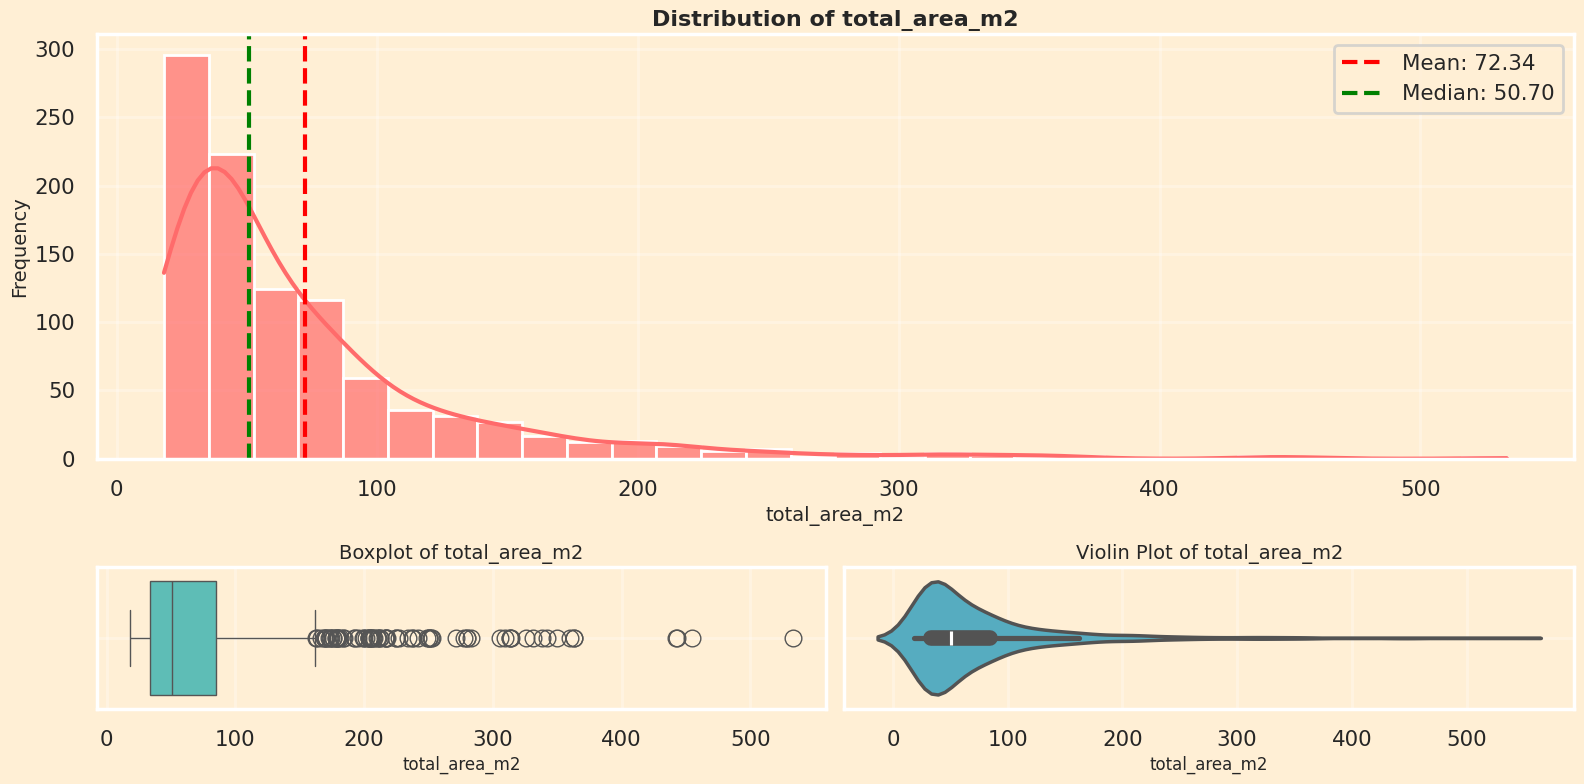

In [59]:
plot_numeric_col(df, 'total_area_m2')

In [60]:
df = df[df['total_area_m2'] <= 210]

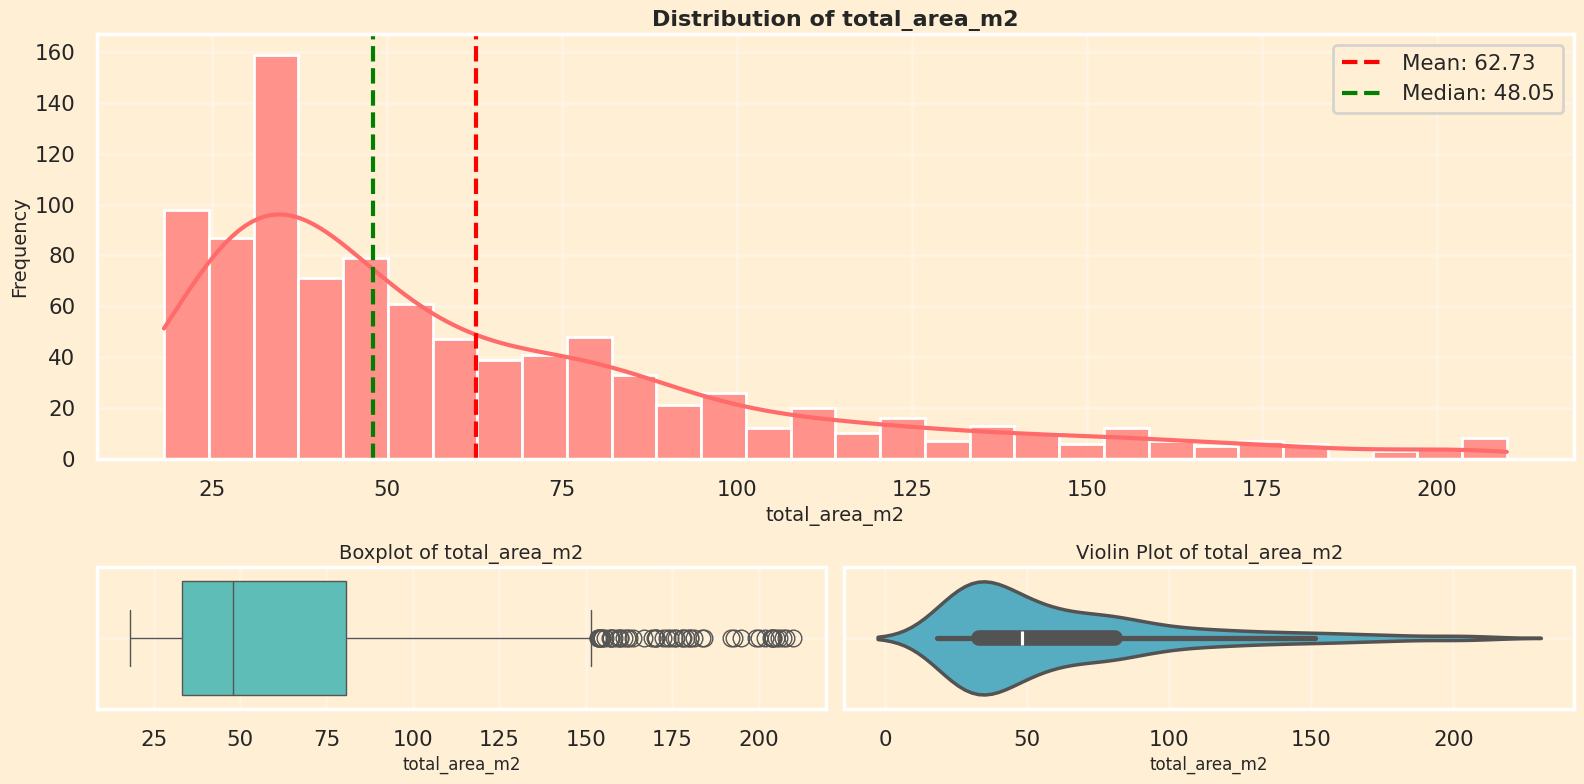

In [61]:
plot_numeric_col(df, 'total_area_m2')

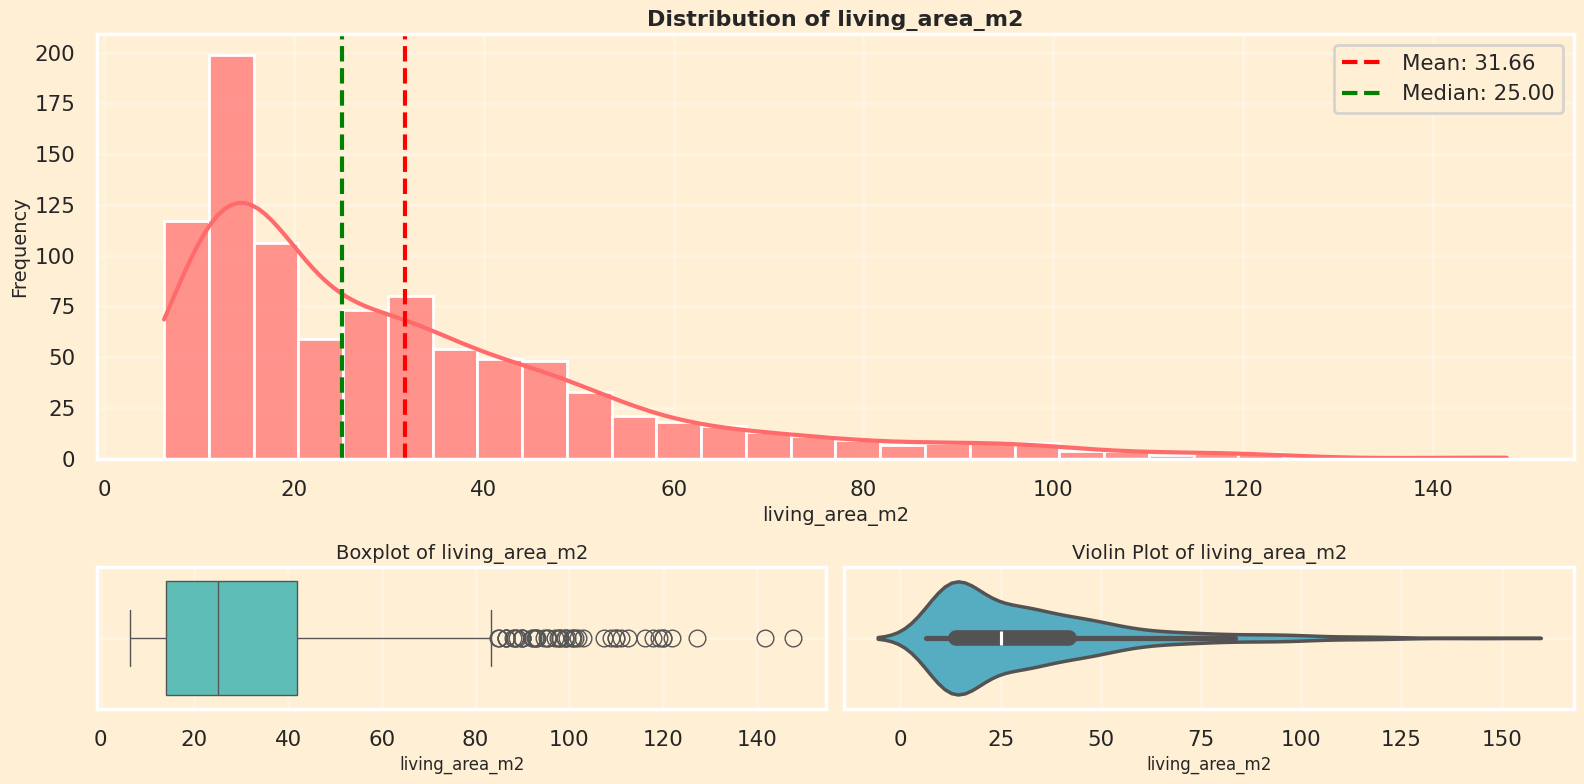

In [62]:
plot_numeric_col(df, 'living_area_m2')

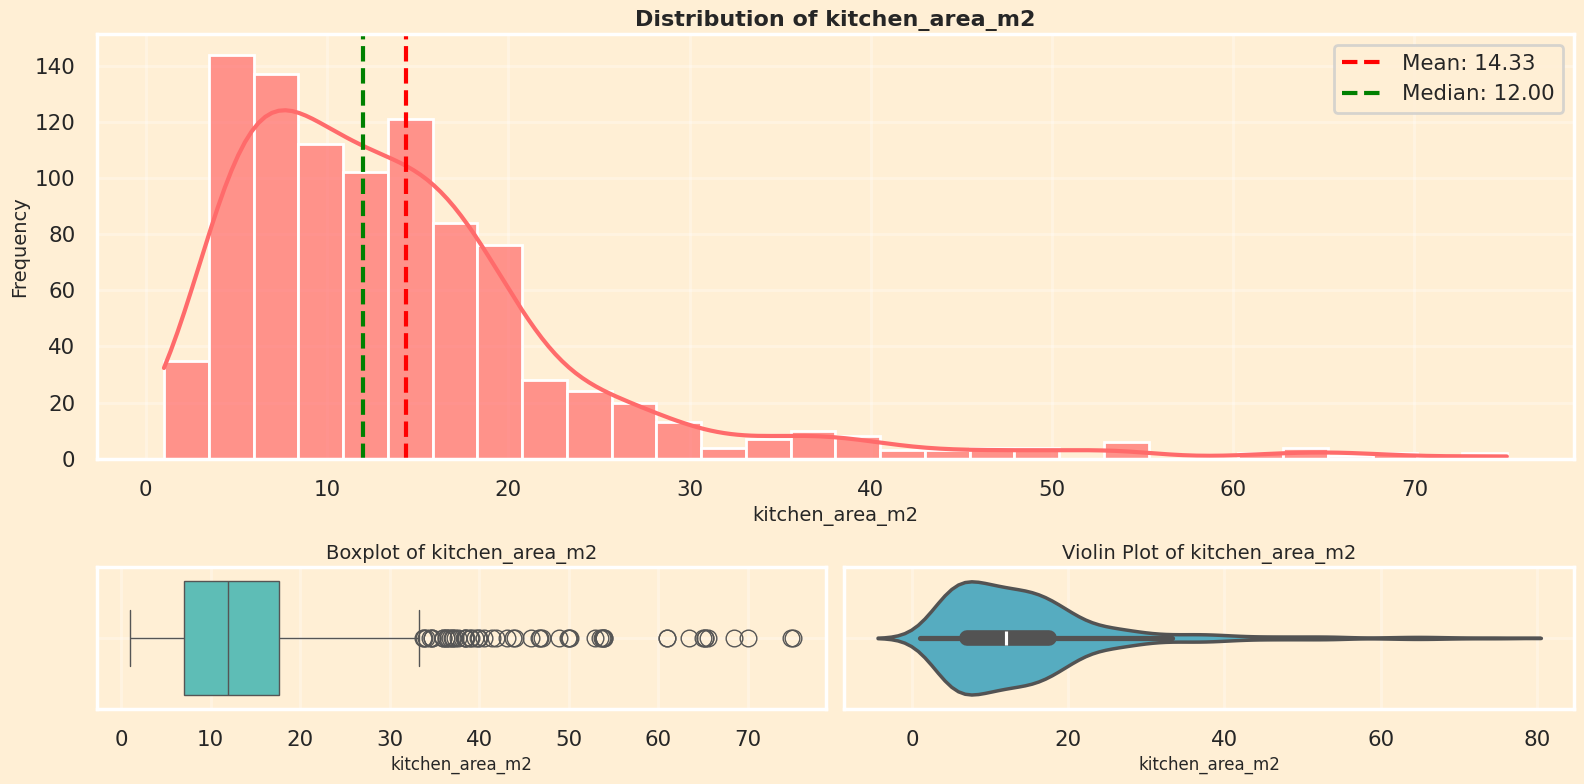

In [63]:
plot_numeric_col(df, 'kitchen_area_m2')

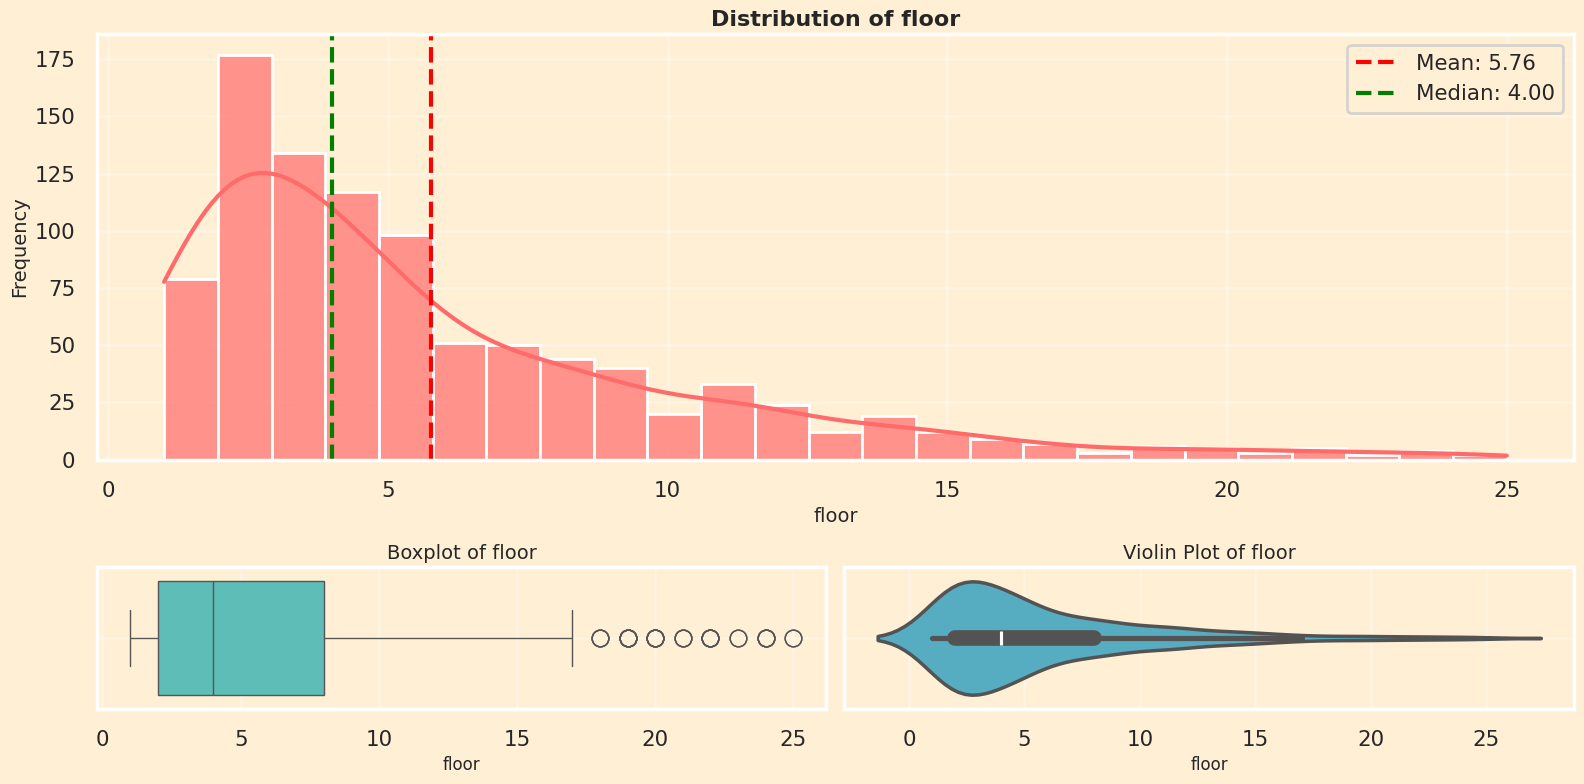

In [64]:
plot_numeric_col(df, 'floor', bins=25)

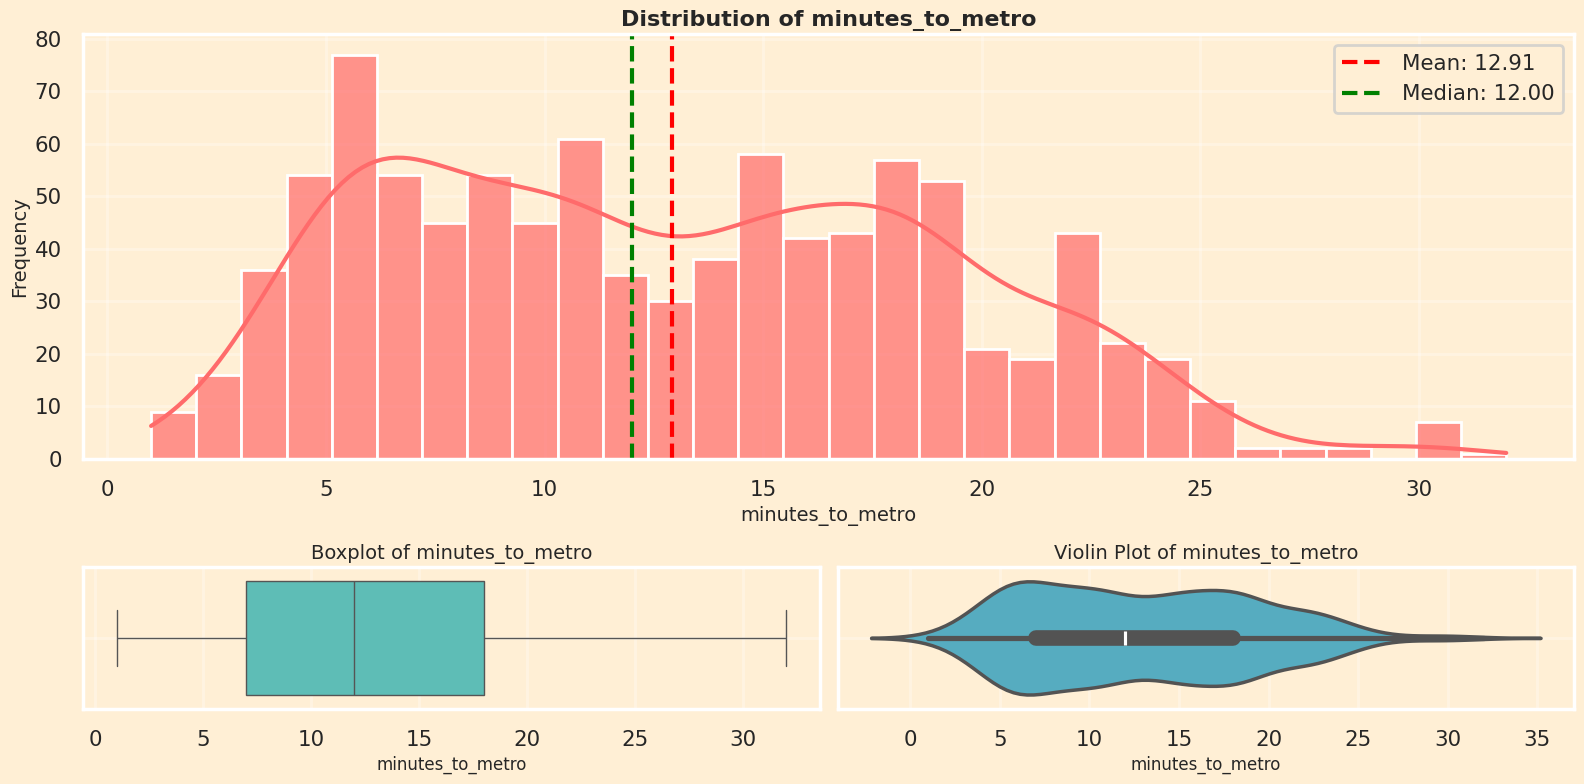

In [65]:
plot_numeric_col(df, 'minutes_to_metro')

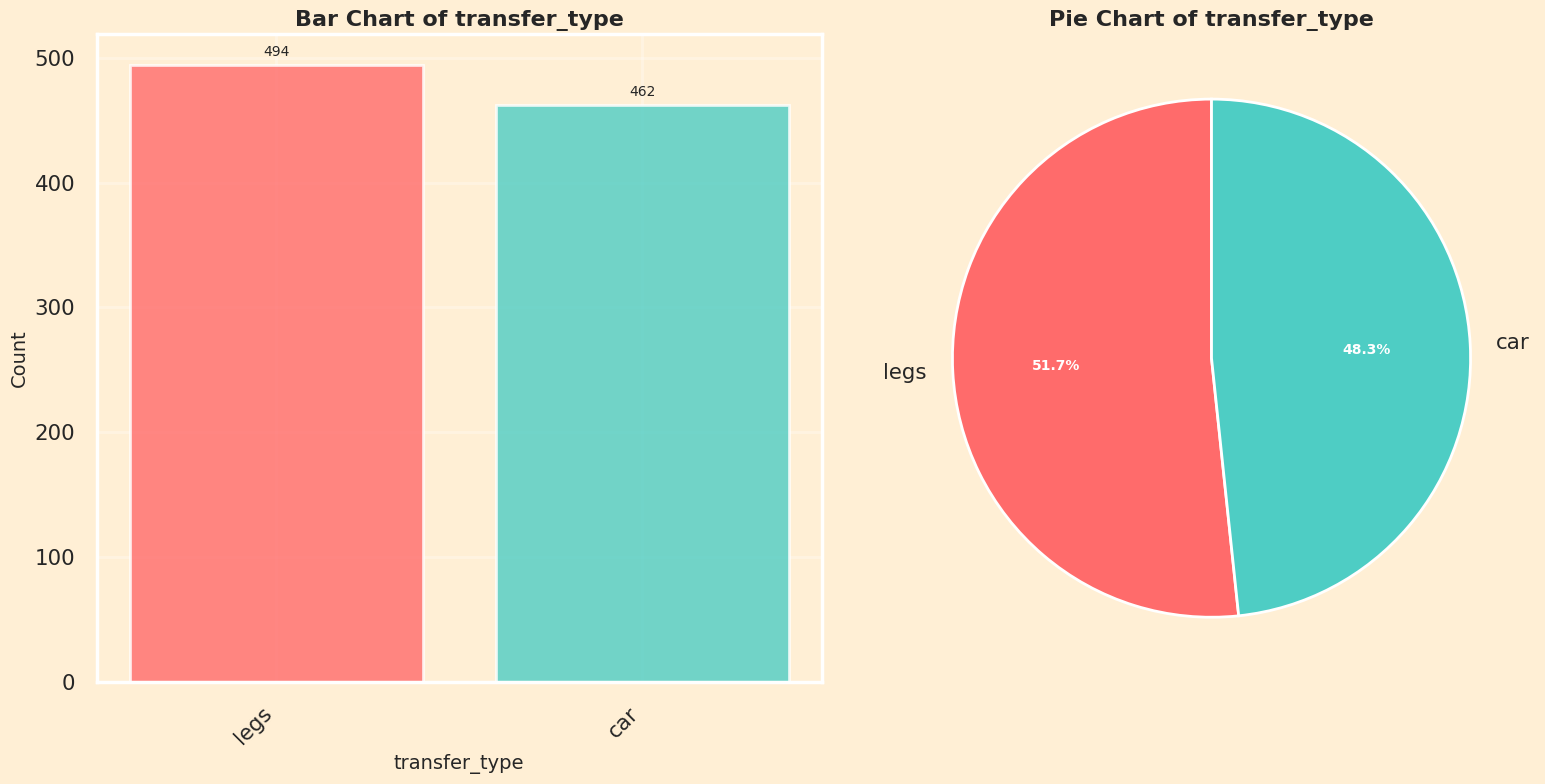

In [66]:
plot_categorical_col(df, 'transfer_type')

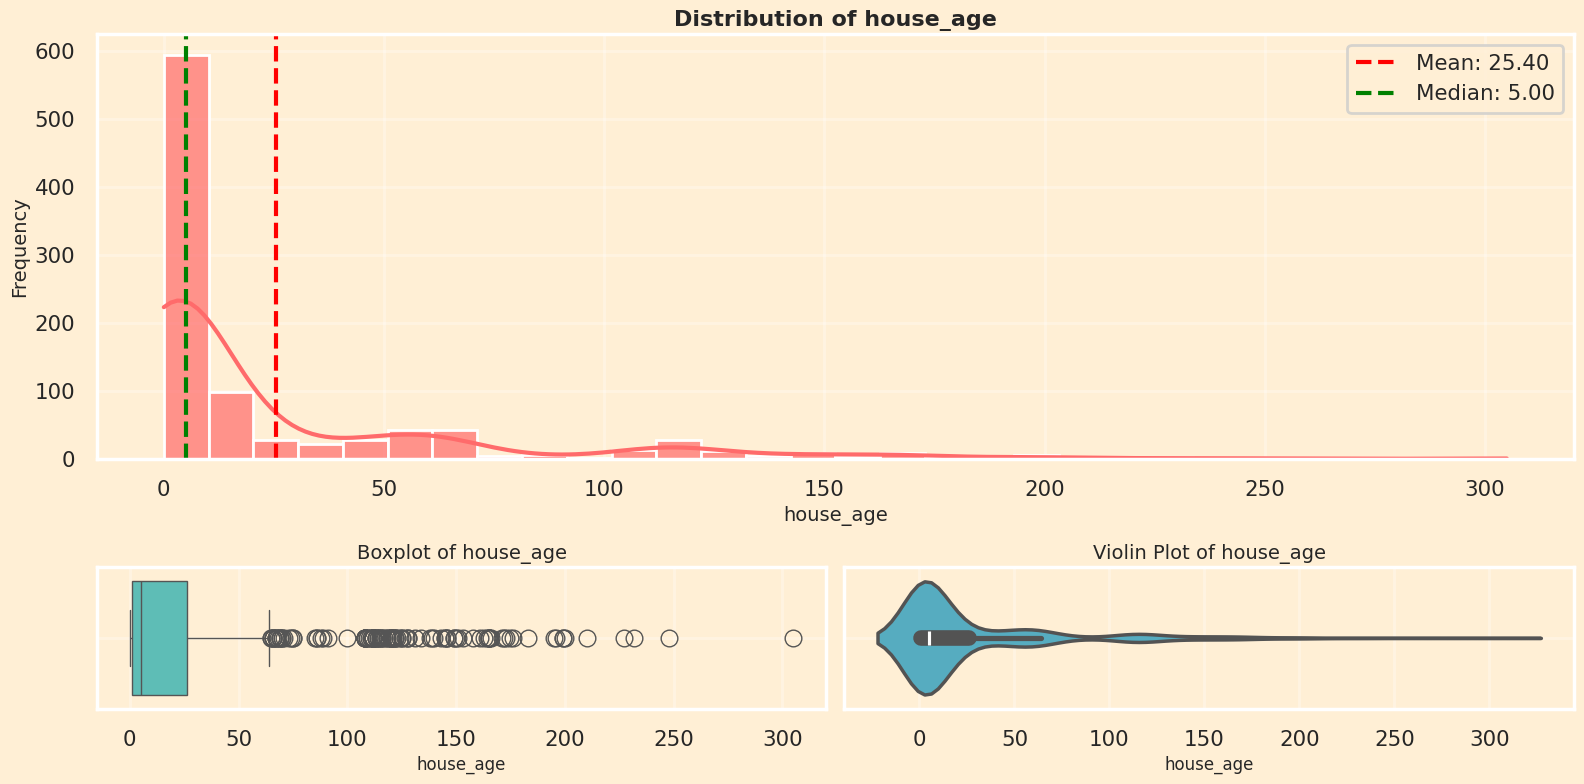

In [67]:
plot_numeric_col(df, 'house_age')

In [68]:
df = df[df['house_age'] <= 150]

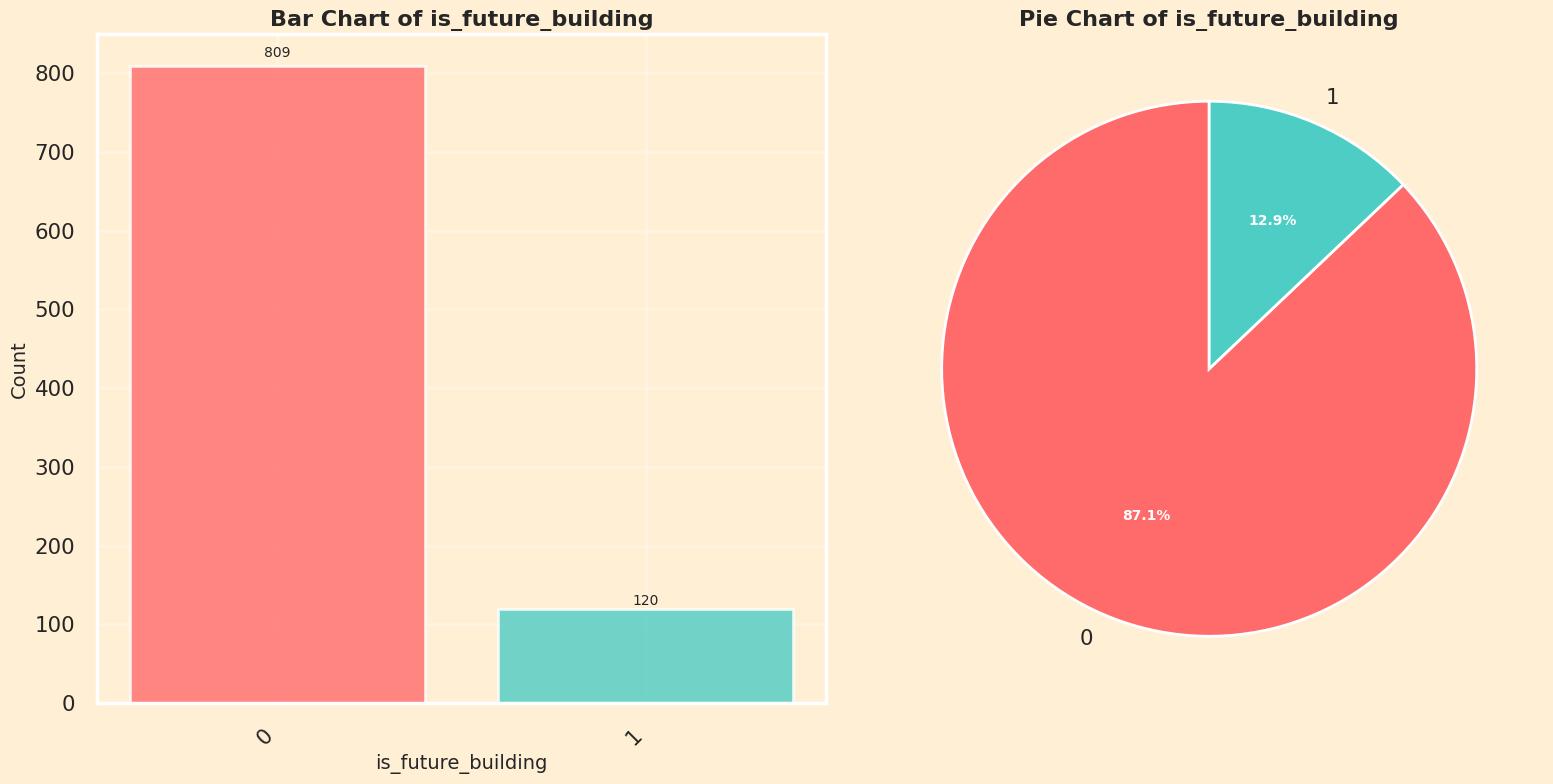

In [69]:
plot_categorical_col(df, 'is_future_building')

In [70]:
shape_after_eda = df.shape
diff = shape_before_eda[0] - shape_after_eda[0]
print(f'Всего удалено строк: {diff}, {diff/shape_before_eda[0]:.2%} % от исходного датасета')

Всего удалено строк: 69, 6.91% % от исходного датасета


## Обучение моделей

In [71]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,car,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,car,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,legs,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,car,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,car,10,0


In [73]:
X = df.drop('price', axis=1)
y = df['price']

In [72]:
num_cols = ['total_area_m2',
            'living_area_m2',
            'kitchen_area_m2',
            'floor',
            'minutes_to_metro',
            'house_age']
cat_cols = ['flat_status',
            'num_of_rooms',
            'metro_station',
            'transfer_type',
            'is_future_building']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
# Укажем юзера который делает эксперименты
os.environ['USER'] = 'Mikhail Lodygin'